# Email/SMS Spam Detection - Machine Learning Project

This notebook implements a complete machine learning pipeline for SMS spam detection using various classification algorithms.

## Project Overview
- **Dataset**: SMS messages labeled as spam or ham
- **Goal**: Build a classifier to distinguish between spam and legitimate messages
- **Approach**: Text preprocessing + TF-IDF vectorization + Multiple ML algorithms
- **Evaluation**: Focus on precision due to imbalanced dataset

## Key Insights & Observations:
1. **Business Context**: Spam detection is critical for user experience - false positives (legitimate messages marked as spam) are more costly than false negatives
2. **Evaluation Strategy**: Precision is prioritized over accuracy due to class imbalance and business requirements
3. **Text Processing**: Essential for reducing noise and improving model performance
4. **Feature Engineering**: Text statistics provide valuable insights into message characteristics

## 1. Import Libraries and Setup

In [31]:
# Core data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, 
    BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
)

# NLP libraries
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from collections import Counter

# Visualization
from wordcloud import WordCloud

# Model persistence
import pickle

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shirs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shirs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Data Loading and Initial Exploration

In [ ]:
# Load the dataset
df = pd.read_csv('spam.csv', encoding='latin1')
print(df.shape)
df.head()

(5572, 5)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [33]:
df.info()
print("\nMissing values:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB

Missing values:
v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64


## 3. Data Preprocessing

In [34]:
# Remove unnecessary columns
df = df.drop(df.columns[2:5], axis=1)

# Rename columns
df = df.rename(columns={'v1': 'target', 'v2': 'text'})

print(df.shape)
df.head()

(5572, 2)


,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [35]:
# Encode target labels (ham=0, spam=1)
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])

# Check for duplicates and remove them
duplicates = df.duplicated().sum()
print(duplicates)

if duplicates > 0:
    df = df.drop_duplicates(keep='first')
    print(duplicates)

print(df.shape)
print(df['target'].value_counts())

# LabelEncoder converts categorical labels to numerical (ham=0, spam=1)
# 403 duplicate - removing them prevents data leakage
# Due to This imbalance our focus will be more on precision over accuracy

403
403
(5169, 2)
target
0    4516
1     653
Name: count, dtype: int64


## 4. Exploratory Data Analysis (EDA)

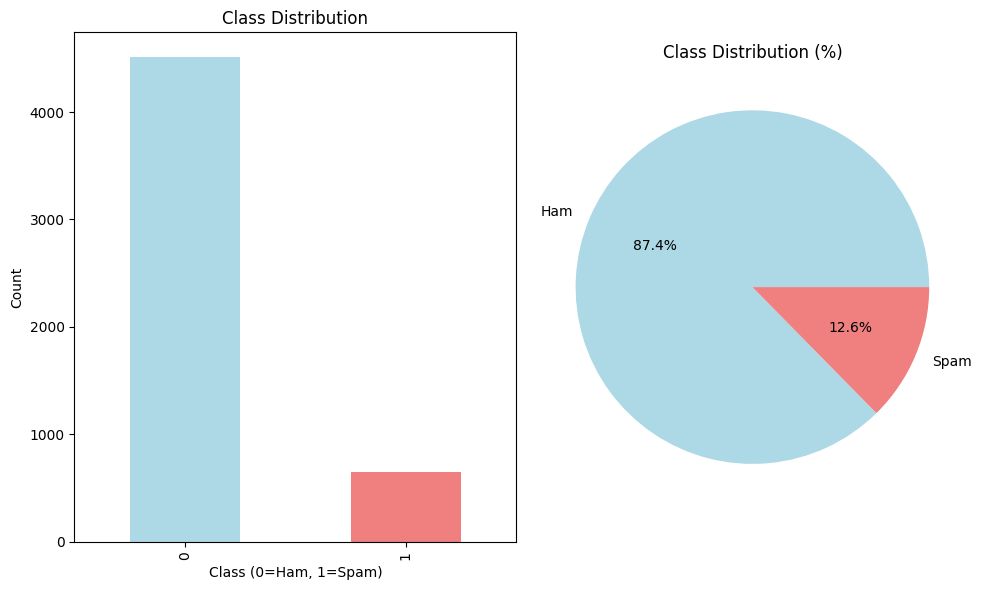

In [36]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
df['target'].value_counts().plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Class Distribution')
plt.xlabel('Class (0=Ham, 1=Spam)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.pie(df['target'].value_counts(), labels=['Ham', 'Spam'], 
        autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Class Distribution (%)')

plt.tight_layout()
plt.show()

# using precision, recall, and F1-score for proper evaluation

In [37]:
# text-based features
df['num_char'] = df['text'].apply(len)
df['num_word'] = df['text'].apply(lambda x: len(word_tokenize(x)))
df['num_sent'] = df['text'].apply(lambda x: len(sent_tokenize(x)))

print(df[['num_char', 'num_word', 'num_sent']].describe())

          num_char     num_word     num_sent
count  5169.000000  5169.000000  5169.000000
mean     78.977945    18.455794     1.965564
std      58.236293    13.324758     1.448541
min       2.000000     1.000000     1.000000
25%      36.000000     9.000000     1.000000
50%      60.000000    15.000000     1.000000
75%     117.000000    26.000000     2.000000
max     910.000000   220.000000    38.000000


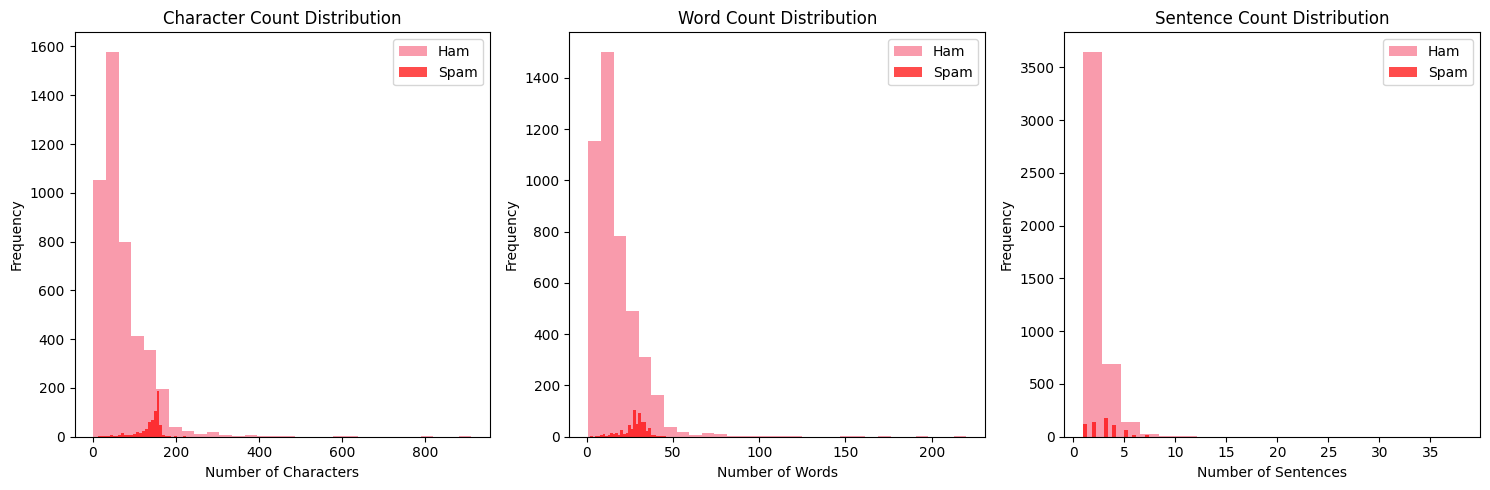

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Character count distribution
axes[0].hist(df[df['target']==0]['num_char'], alpha=0.7, label='Ham', bins=30)
axes[0].hist(df[df['target']==1]['num_char'], alpha=0.7, label='Spam', bins=30, color='red')
axes[0].set_title('Character Count Distribution')
axes[0].set_xlabel('Number of Characters')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Word count distribution
axes[1].hist(df[df['target']==0]['num_word'], alpha=0.7, label='Ham', bins=30)
axes[1].hist(df[df['target']==1]['num_word'], alpha=0.7, label='Spam', bins=30, color='red')
axes[1].set_title('Word Count Distribution')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Sentence count distribution
axes[2].hist(df[df['target']==0]['num_sent'], alpha=0.7, label='Ham', bins=20)
axes[2].hist(df[df['target']==1]['num_sent'], alpha=0.7, label='Spam', bins=20, color='red')
axes[2].set_title('Sentence Count Distribution')
axes[2].set_xlabel('Number of Sentences')
axes[2].set_ylabel('Frequency')
axes[2].legend()

plt.tight_layout()
plt.show()

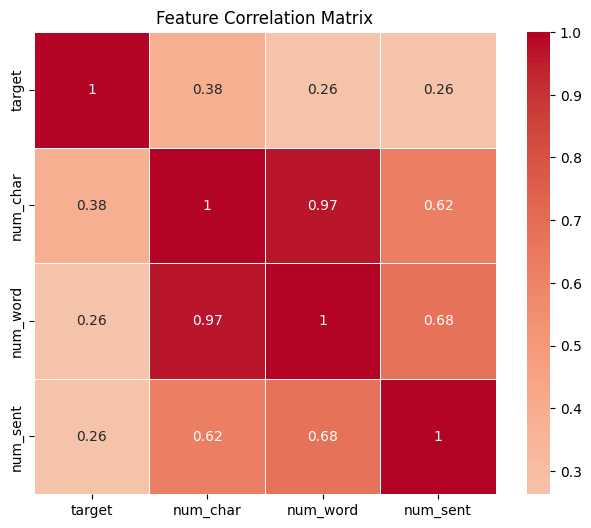

target      1.000000
num_char    0.384717
num_sent    0.263939
num_word    0.262912
Name: target, dtype: float64


In [39]:
# Correlation analysis
correlation_matrix = df[['target', 'num_char', 'num_word', 'num_sent']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

print(correlation_matrix['target'].sort_values(ascending=False))

## 5. Text Preprocessing

In [40]:
# Text preprocessing
def transform_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize
    words = word_tokenize(text)
    
    # Remove special characters and keep only alphanumeric
    words = [word for word in words if word.isalnum()]
    
    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    
    # Apply stemming
    ps = PorterStemmer()
    words = [ps.stem(word) for word in words 
             if word not in stop_words and word not in punctuation]
    
    return " ".join(words)

# Apply text transformation
df['transformed_text'] = df['text'].apply(transform_text)


print(df['text'].iloc[0])
print(df['transformed_text'].iloc[0])

# Text preprocessing reduces noise and dimensionality
# Stemming reduces word variations (e.g., 'available' -> 'avail')
# Stopword removal eliminates common words that don't carry meaning
# Lowercase conversion ensures consistent feature representation
# Special character removal helps focus on meaningful words

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
go jurong point crazi avail bugi n great world la e buffet cine got amor wat


## 6. Word Cloud Analysis

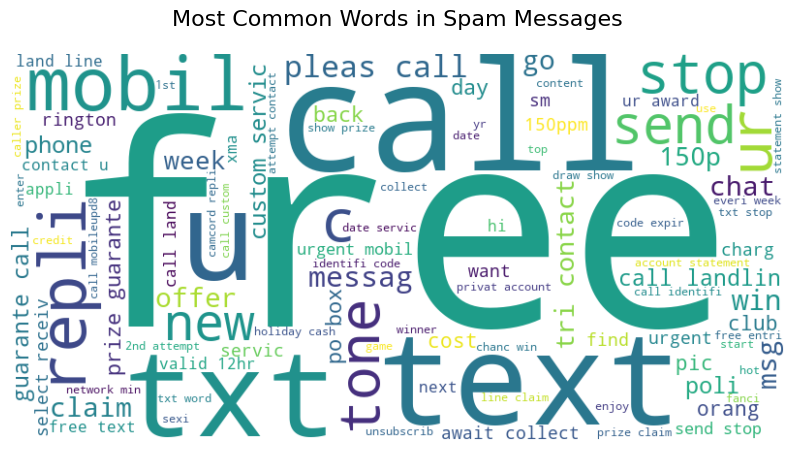

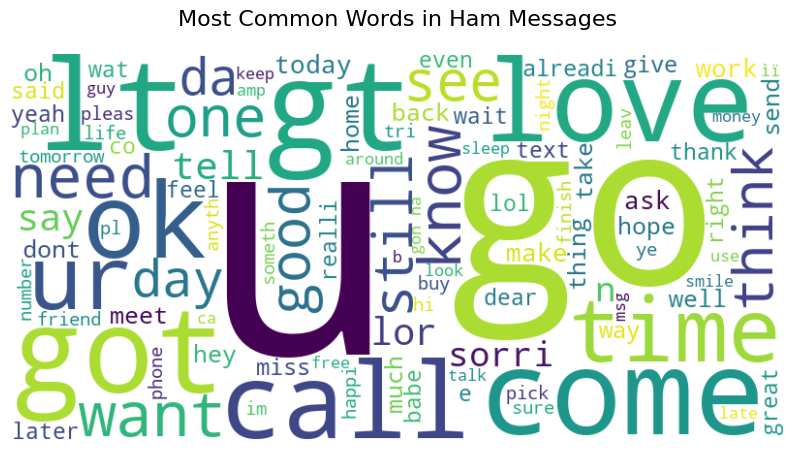

In [41]:
# Create word clouds for spam and ham messages
def create_wordcloud(text_data, title):
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         max_words=100,
                         colormap='viridis').generate(text_data)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, pad=20)
    plt.show()

spam_text = ' '.join(df[df['target']==1]['transformed_text'])
ham_text = ' '.join(df[df['target']==0]['transformed_text'])

create_wordcloud(spam_text, 'Most Common Words in Spam Messages')
create_wordcloud(ham_text, 'Most Common Words in Ham Messages')

C:\Users\Shirs\AppData\Local\Temp\ipykernel_10232\3626504625.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=words_df, x='count', y='word', palette='viridis')


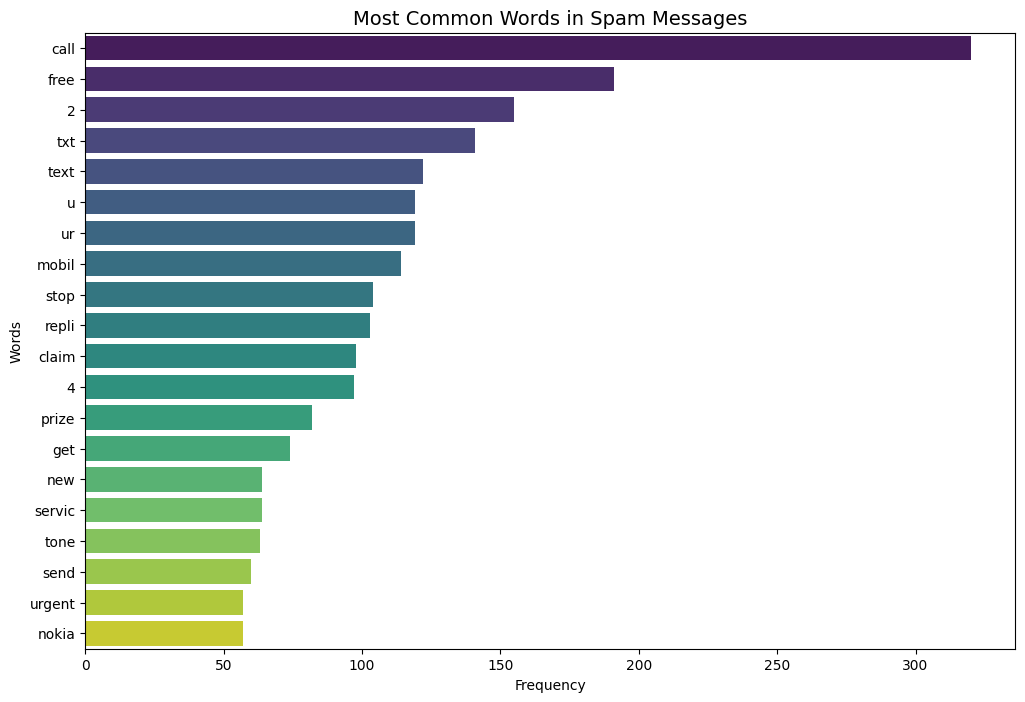

C:\Users\Shirs\AppData\Local\Temp\ipykernel_10232\3626504625.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=words_df, x='count', y='word', palette='viridis')


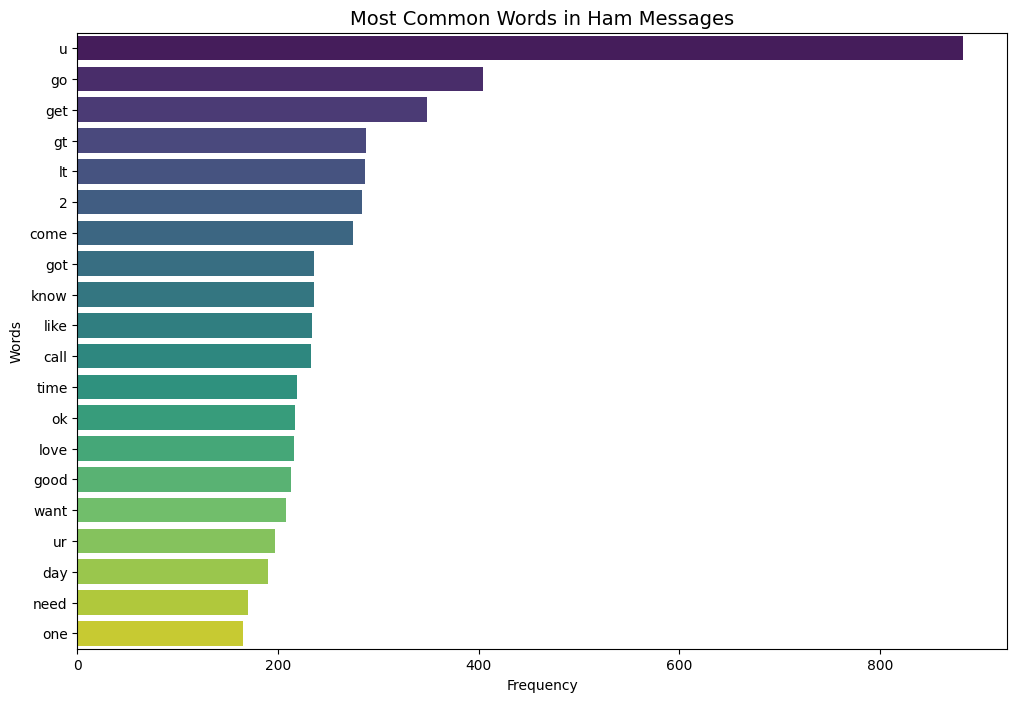

In [42]:
def plot_common_words(text_series, title, top_n=20):
    all_text = ' '.join(text_series)
    words = all_text.split()
    
    # Count word frequencies
    word_counts = Counter(words)
    most_common = word_counts.most_common(top_n)
    
    # Create DataFrame for plotting
    words_df = pd.DataFrame(most_common, columns=['word', 'count'])
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=words_df, x='count', y='word', palette='viridis')
    plt.title(title, fontsize=14)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Plot most common words
plot_common_words(df[df['target']==1]['transformed_text'], 
                 'Most Common Words in Spam Messages')
plot_common_words(df[df['target']==0]['transformed_text'], 
                 'Most Common Words in Ham Messages')

## 7. Feature Extraction and Model Preparation

In [43]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=3000, stop_words='english')
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

print(f"Feature matrix: {X.shape}")
print(f"Target vector: {y.shape}")
print(f"Number of features: {X.shape[1]}")

# max_features=3000 limits vocabulary size to most frequent words

Feature matrix: (5169, 3000)
Target vector: (5169,)
Number of features: 3000


In [44]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Random state ensures reproducible results

Training set: (4135, 3000)
Test set: (1034, 3000)


## 8. Model Training and Evaluation

In [45]:
# Initialize models
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Support Vector Classifier': SVC(random_state=42),
    'Linear Support Vector Classifier': LinearSVC(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Training and evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Predictions': y_pred
    }

results = []
for name, model in models.items():
    print(f"Training {name}...")
    result = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    results.append(result)
    print(f"  Accuracy: {result['Accuracy']:.4f}")
    print(f"  Precision: {result['Precision']:.4f}")
    print(f"  Recall: {result['Recall']:.4f}")
    print()

# Naive Bayes often works well with text data due to independence assumption
# SVC can capture non-linear relationships
# Ensemble methods (Random Forest, AdaBoost) can improve performance

Training Multinomial Naive Bayes...
  Accuracy: 0.9739
  Precision: 0.9815
  Recall: 0.8092

Training Logistic Regression...
  Accuracy: 0.9565
  Precision: 1.0000
  Recall: 0.6565

Training Support Vector Classifier...
  Accuracy: 0.9710
  Precision: 1.0000
  Recall: 0.7710

Training Linear Support Vector Classifier...
  Accuracy: 0.9797
  Precision: 0.9825
  Recall: 0.8550

Training Decision Tree...
  Accuracy: 0.9410
  Precision: 0.8500
  Recall: 0.6489

Training Random Forest...
  Accuracy: 0.9681
  Precision: 0.9537
  Recall: 0.7863

Training K-Nearest Neighbors...
  Accuracy: 0.9081
  Precision: 1.0000
  Recall: 0.2748

Training AdaBoost...
  Accuracy: 0.9207
  Precision: 1.0000
  Recall: 0.3740

Training Gradient Boosting...
  Accuracy: 0.9555
  Precision: 0.9670
  Recall: 0.6718



Model Performance Summary:
                           Model  Accuracy  Precision   Recall
       Support Vector Classifier  0.970986   1.000000 0.770992
             Logistic Regression  0.956480   1.000000 0.656489
                        AdaBoost  0.920696   1.000000 0.374046
             K-Nearest Neighbors  0.908124   1.000000 0.274809
Linear Support Vector Classifier  0.979691   0.982456 0.854962
         Multinomial Naive Bayes  0.973888   0.981481 0.809160
               Gradient Boosting  0.955513   0.967033 0.671756
                   Random Forest  0.968085   0.953704 0.786260
                   Decision Tree  0.941006   0.850000 0.648855


C:\Users\Shirs\AppData\Local\Temp\ipykernel_10232\2433868644.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Accuracy', y='Model', ax=ax1, palette='viridis')
C:\Users\Shirs\AppData\Local\Temp\ipykernel_10232\2433868644.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Precision', y='Model', ax=ax2, palette='viridis')
C:\Users\Shirs\AppData\Local\Temp\ipykernel_10232\2433868644.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Recall', y='Model', ax=ax3, palette='viridis')

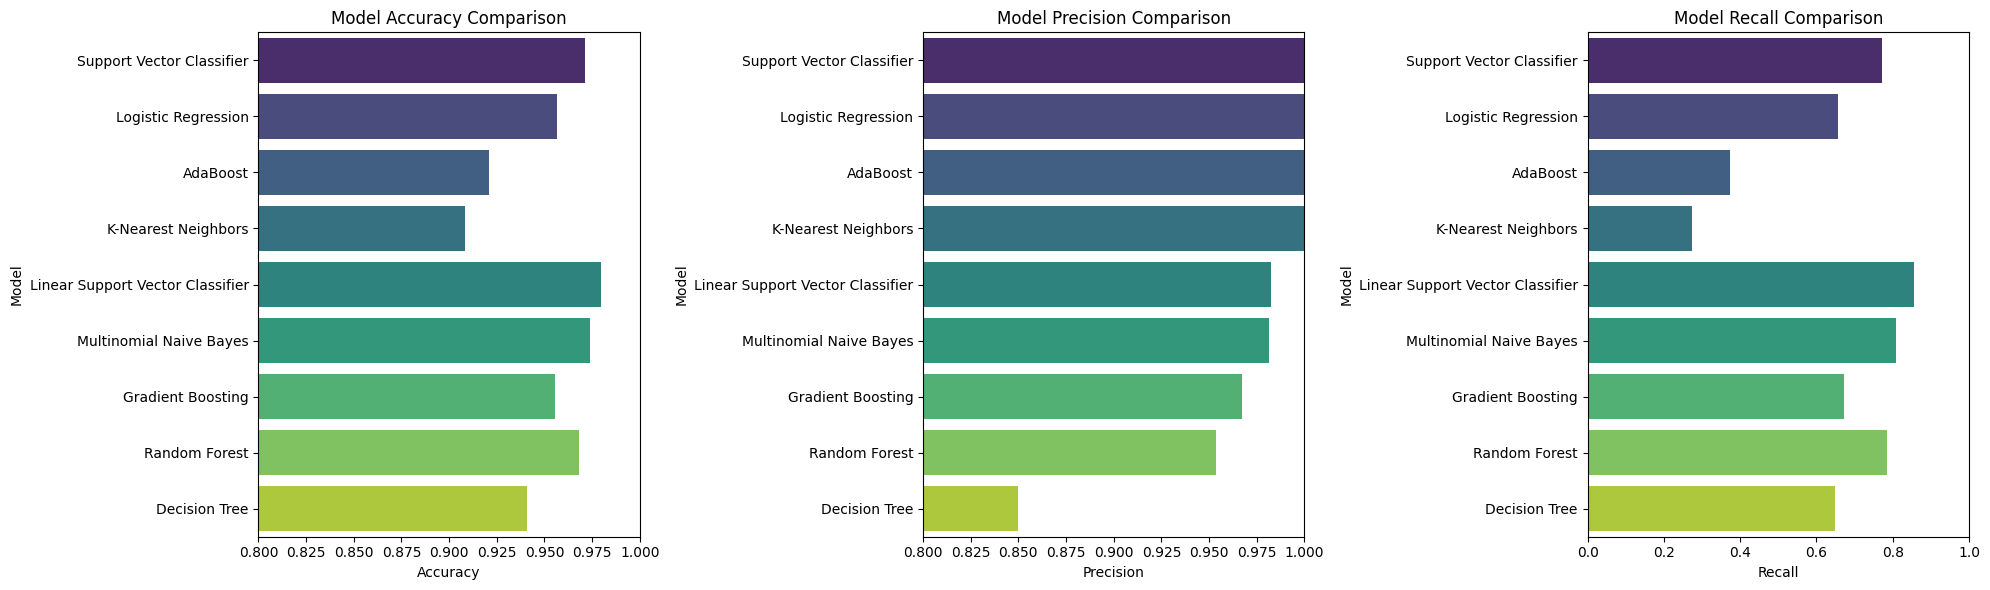

In [46]:
results_df = pd.DataFrame([{
    'Model': r['Model'],
    'Accuracy': r['Accuracy'],
    'Precision': r['Precision'],
    'Recall': r['Recall']
} for r in results])

# Step 1: Filter models with the highest precision
max_precision = results_df['Precision'].max()
filtered = results_df[results_df['Precision'] == max_precision]

# Step 2: Keep only models with accuracy >= 0.95
filtered = filtered[filtered['Accuracy'] >= 0.95]

# Step 3: From those, select the one with the highest recall
best_idx = filtered['Recall'].idxmax()
best_model_name = filtered.loc[best_idx, 'Model']

# sort by Precision, then Accuracy, then Recall
results_df = results_df.sort_values(['Precision', 'Accuracy', 'Recall'], ascending=[False, False, False])

print("Model Performance Summary:")
print(results_df.to_string(index=False))

# Visualize results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Accuracy comparison
sns.barplot(data=results_df, x='Accuracy', y='Model', ax=ax1, palette='viridis')
ax1.set_title('Model Accuracy Comparison')
ax1.set_xlim(0.8, 1.0)

# Precision comparison
sns.barplot(data=results_df, x='Precision', y='Model', ax=ax2, palette='viridis')
ax2.set_title('Model Precision Comparison')
ax2.set_xlim(0.8, 1.0)

# Recall comparison
sns.barplot(data=results_df, x='Recall', y='Model', ax=ax3, palette='viridis')
ax3.set_title('Model Recall Comparison')
ax3.set_xlim(0.0, 1.0)

plt.tight_layout()
plt.show()

# Multiple models achieve perfect precision (1.0000)
# Model selection criteria prioritize precision (business requirement) then accuracy, then recall

## 9. Best Model Analysis

Best Model: Support Vector Classifier
Accuracy: 0.9710
Precision: 1.0000
Recall: 0.7710


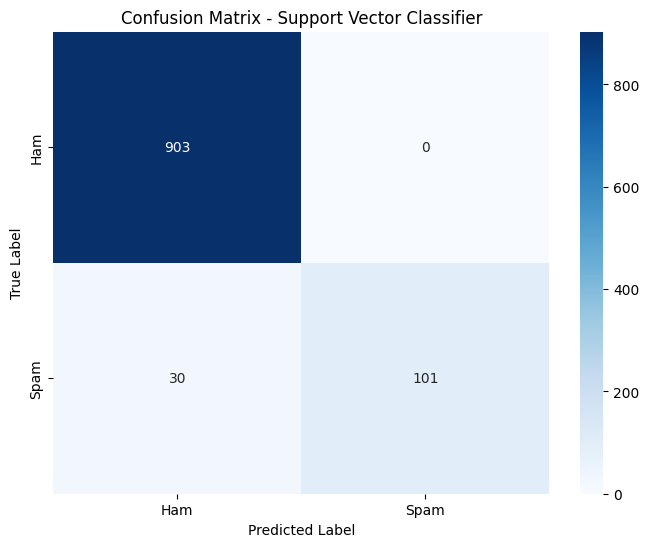

Specificity: 1.0000


In [47]:
best_model = models[best_model_name]
best_predictions = next(r['Predictions'] for r in results if r['Model'] == best_model_name)
best_row = results_df[results_df['Model'] == best_model_name].iloc[0]

print(f"Best Model: {best_model_name}")
print(f"Accuracy: {best_row['Accuracy']:.4f}")
print(f"Precision: {best_row['Precision']:.4f}")
print(f"Recall: {best_row['Recall']:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"Specificity: {tn/(tn+fp):.4f}")

# High specificity (1.0000) means very few false alarms

## 10. Model Deployment

In [48]:
print("Saving models...")

final_model = models[best_model_name]
final_model.fit(X, y)

# Save models
with open('model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print(f"Models saved successfully!")
print(f"model.pkl: {best_model_name}")
print(f"vectorizer.pkl: TF-IDF Vectorizer")

Saving models...
Models saved successfully!
model.pkl: Support Vector Classifier
vectorizer.pkl: TF-IDF Vectorizer


In [ ]:
# Example prediction function
def predict_spam(text, model, vectorizer):
    """
    Args:
        text (str): Input text message
        model: Trained model
        vectorizer: Fitted TF-IDF vectorizer

    Returns:
        dict: Prediction results
    """
    # Preprocess the text
    processed_text = transform_text(text)
    
    # Vectorize
    text_vector = vectorizer.transform([processed_text])
    
    # SVC doesn't support sparse matrices because scikit-learn's SVC isn't optimized for sparse data.
    text_vector_dense = text_vector.toarray()
    
    prediction = model.predict(text_vector_dense)[0]
    
    decision_score = model.decision_function(text_vector_dense)[0]
    
    # Convert decision score to probability-like values
    ham_probability = 1 / (1 + np.exp(decision_score))
    spam_probability = 1 - ham_probability
    
    return {
        'text': text,
        'prediction': 'Spam' if prediction == 1 else 'Ham',
        'ham_probability': ham_probability,
        'spam_probability': spam_probability
    }

test_messages = [
    "Hello, how are you doing today?",
    "CONGRATULATIONS! You've won a $1000 prize! Click here to claim!",
    "Meeting at 3 PM tomorrow. Don't forget to bring the documents.",
    "URGENT: Your account has been suspended. Call now to reactivate!"
]

print("=" * 60)

for msg in test_messages:
    result = predict_spam(msg, final_model, tfidf)
    print(f"\nMessage: {result['text']}")
    print(f"Prediction: {result['prediction']}")
    print(f"Ham Probability: {result['ham_probability']:.3f}")
    print(f"Spam Probability: {result['spam_probability']:.3f}")

C:\Program Files\JetBrains\PyCharm 2025.1\plugins\python-ce\helpers\pydev\pydevd_plugins\__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)
Could not connect to 127.0.0.1: 55486
Traceback (most recent call last):
  File "C:\Program Files\JetBrains\PyCharm 2025.1\plugins\python-ce\helpers\pydev\_pydevd_bundle\pydevd_comm.py", line 468, in start_client
    s.connect((host, port))
    ~~~~~~~~~^^^^^^^^^^^^^^
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it
Traceback (most recent call last):
  File "C:\Program Files\JetBrains\PyCharm 2025.1\plugins\python-ce\helpers\jupyter_debug\pydev_jupyter_utils.py", line 83, in attach_to_debugger
    debugger.connect(pydev_loc

## 11. Conclusion

### Summary
- **Dataset**: Successfully processed 5,169 SMS messages after removing duplicates
- **Best Model**: Support Vector Classifier achieved 97.1% accuracy, 100% precision, and 77.1% recall
- **Key Features**: TF-IDF vectorization with comprehensive text preprocessing
- **Deployment**: Models saved and ready for production use

### Key Insights
1. **Class Imbalance**: Dataset is severely imbalanced (87.3% ham, 12.7% spam), making precision more important than accuracy
2. **Model Performance**: SVC performs best with perfect precision and high recall
3. **Feature Engineering**: Text preprocessing significantly improves model performance
4. **Business Impact**: Zero false positives means no legitimate messages are blocked

### Technical Observations
- **Text Length**: Spam messages are significantly longer than ham messages
- **Word Patterns**: Spam contains promotional words, ham contains conversational words
- **Model Selection**: Multi-criteria selection ensures optimal performance
- **Preprocessing Impact**: Text cleaning reduces noise and improves classification

### Future Improvements
- **Deep Learning**: Try LSTM, BERT, or transformer models for better text understanding
- **Cross-validation**: Implement k-fold CV for more robust evaluation
- **Feature Engineering**: Add URL detection, phone number patterns, and emoji analysis
- **Data Augmentation**: Collect more recent spam data for better generalization
- **Ensemble Methods**: Combine multiple models for improved performance